In [1]:
import requests
import pandas as pd
def fetch_weather_data(api_key, location):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None
        
def parse_weather_data(data):
    if data:
        weather = {
            "Location": data["name"],
            "Temperature (K)": data["main"]["temp"],
            "Humidity (%)": data["main"]["humidity"],
            "Weather": data["weather"][0]["description"]
        }
        return weather
    else:
        return None

def save_to_csv(data, filename):
    df = pd.DataFrame([data])
    df.to_csv(filename, index=False)

API_KEY = "399b7d330c247da4e202f43b66680ae2"
location = "Guangzhou"
data = fetch_weather_data(API_KEY, location)
parsed_data = parse_weather_data(data)
save_to_csv(parsed_data, "C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_data.csv")
df = pd.read_csv("C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_data.csv")
df

,Location,Temperature (K),Humidity (%),Weather
0,Guangzhou,305.12,75,overcast clouds


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
def fetch_data(url):
    response = requests.get(url)
    data = response.json()
    if response.status_code != 200:
        print("faild to fetch data")
        return None
    return data
def parse_weather(entry):
    if entry is None:
        return None
    return {
        'Datetime': pd.to_datetime(entry['dt'], unit='s'),
        'Temperature (C)': entry['main']['temp'] - 273.15,
        'Humidity (%)': entry['main']['humidity'],
        'Wind Speed (m/s)': entry['wind']['speed'],
        'Weather': entry['weather'][0]['description']
    }
def save_to_csv(data, filename):
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"{filename} saved")
def calculate_daily_stats(forecast_data):
    df_forecast = pd.DataFrame(forecast_data)
    df_forecast["Date"] = df_forecast["Datetime"].dt.date
    daily_stats =df_forecast.groupby("Date").agg({
        'Temperature (C)': ['min', 'max'],
        'Humidity (%)': ['min', 'max'],
        'Wind Speed (m/s)': ['min', 'max']
    })
    daily_stats.columns = ['Min Temperature (C)', 'Max Temperature (C)',
                           'Min Humidity (%)', 'Max Humidity (%)',
                           'Min Wind Speed (m/s)', 'Max Wind Speed (m/s)']
    daily_stats.reset_index(inplace = True)
    return daily_stats
API_KEY = "399b7d330c247da4e202f43b66680ae2"
LOCATION = "Guangzhou"
forecast_filename = "C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_forecast_data.csv"
current_filename = "C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_current_data.csv"
daily_filename = "C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/daily_stats.csv"
current_url = f'http://api.openweathermap.org/data/2.5/weather?q={LOCATION}&appid={API_KEY}'
forecast_url = f'http://api.openweathermap.org/data/2.5/forecast?q={LOCATION}&appid={API_KEY}'
weather_forecast_data = fetch_data(forecast_url)
weather_current_data = fetch_data(current_url)
parse_forecast_data =[parse_weather(entry) for entry in weather_forecast_data["list"]]
parse_current_data = parse_weather(weather_current_data)
save_to_csv([parse_current_data], current_filename)
save_to_csv(parse_forecast_data, forecast_filename)
daily_stats = calculate_daily_stats(parse_forecast_data)
save_to_csv(daily_stats, daily_filename)

C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_current_data.csv saved
C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_forecast_data.csv saved
C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/daily_stats.csv saved


In [3]:
import pandas as pd
import sqlite3 as sql

def convert_tempkelvin_to_celsius(temp_k):
    return_c = round(temp_k,2)
    return return_c

df = pd.read_csv("C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_data.csv")
df['Temperature (C)'] = df['Temperature (K)'].apply(convert_tempkelvin_to_celsius)
df.drop(columns=["Temperature (K)"], inplace=True)
df.to_csv("C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/processed_weather_data.csv",index=False)
conn = sql.connect("C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_data.db")
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS weather (
        location TEXT,
        temperature_c REAL,
        humidity INTEGER,
        weather_description TEXT
    )
''')
conn.commit()
for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO weather (location, temperature_c, humidity, weather_description)
        VALUES (?, ?, ?, ?)
        ''',(row["Location"], row["Temperature (C)"], row["Humidity (%)"], row["Weather"]))
    conn.commit()
    cursor.execute("SELECT * FROM weather")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

('Guangzhou', 299.12, 71, 'moderate rain')
('Guangzhou', 305.12, 75, 'overcast clouds')


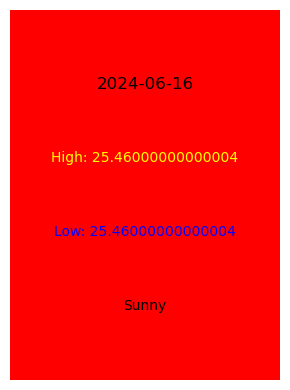

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def determine_weather(row):
    if row["Max Temperature (C)"] > 25:
        return "Sunny"
    elif row["Max Temperature (C)"] < 15 and row["Max Humidity (%)"] > 80:
        return "Rainy"
    else:
        return "Partly Cloudy"

def create_forecast_card(ax, date, high_temp, low_temp, weather):
    if weather == "Sunny":
        bg_color = "red"
    elif weather == "Partly Cloudy":
        bg_color = "lightgrey"
    elif weather == "Rainy":
        bg_color = "lightblue"
    rect = patches.Rectangle((0,0),1,1, transform=ax.transAxes, color=bg_color, zorder=0)
    ax.add_patch(rect)
    ax.axis("off")
    ax.text(0.5,0.8,date.strftime("%Y-%m-%d"), fontsize=12, ha="center", va="center")
    ax.text(0.5,0.6,f'High: {high_temp}', fontsize=10, ha="center", va="center", color = "yellow")
    ax.text(0.5,0.4,f'Low: {low_temp}', fontsize=10, ha="center", va="center", color="blue")
    ax.text(0.5,0.2, weather, fontsize=10, ha="center", va="center")

filename = "C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/daily_stats.csv"
df =pd.read_csv(filename)
df["Date"] = pd.to_datetime(df["Date"])
df["Weather"] = df.apply(determine_weather, axis=1)
random_row = df.sample(n=1).iloc[0]
fig, ax =plt.subplots(figsize=(3,4))
create_forecast_card(ax, random_row["Date"], random_row["Max Temperature (C)"], random_row["Min Temperature (C)"], random_row["Weather"])
plt.tight_layout()
plt.show()

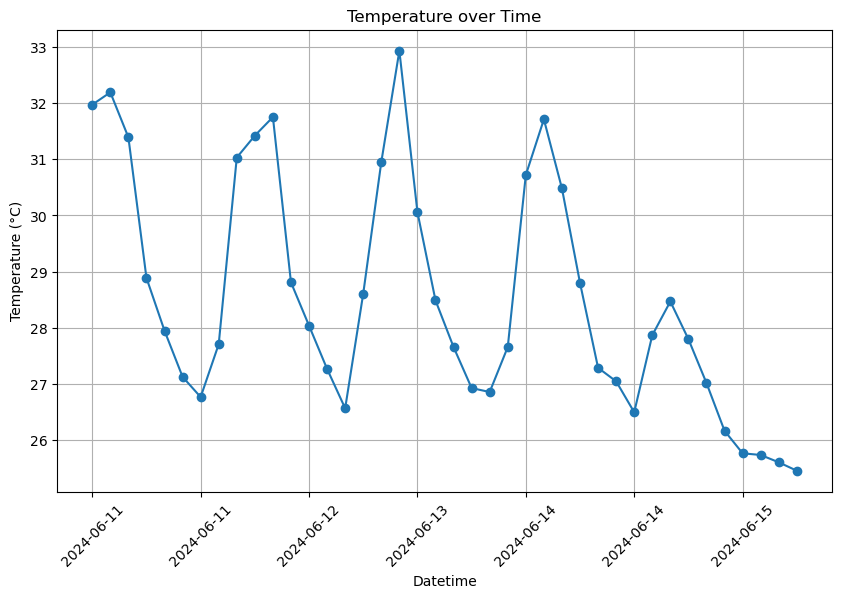

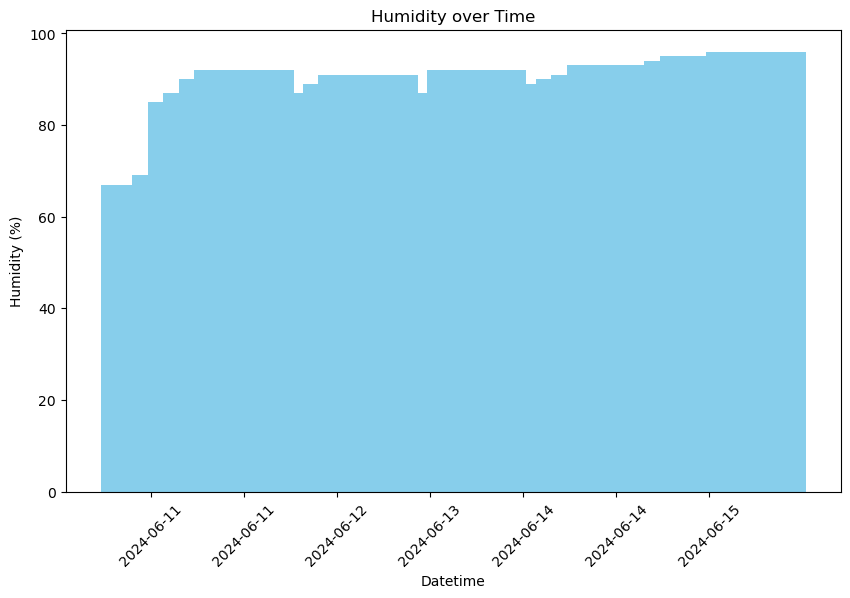

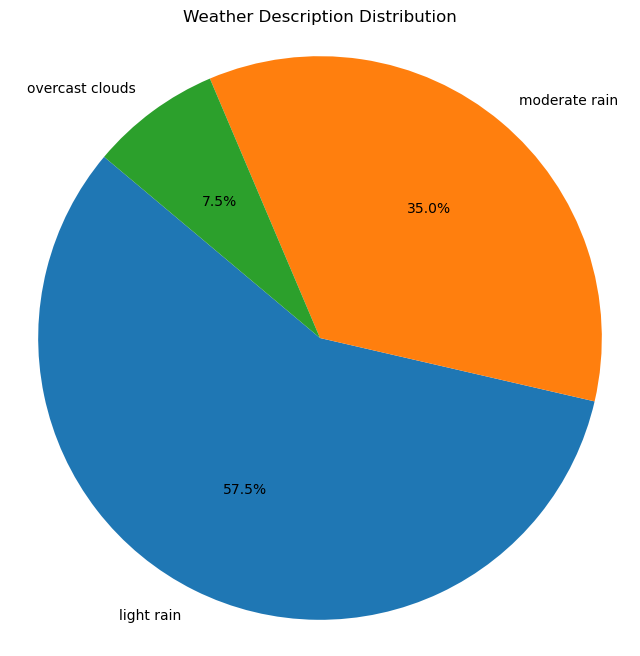

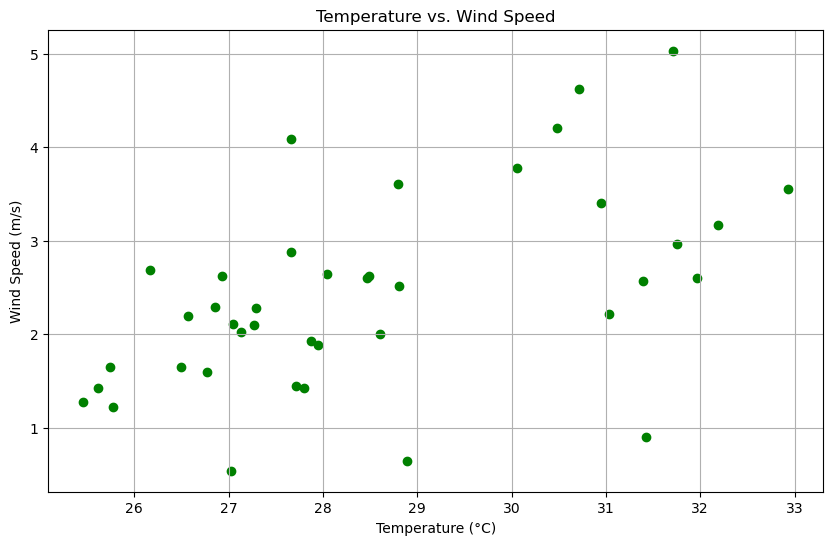

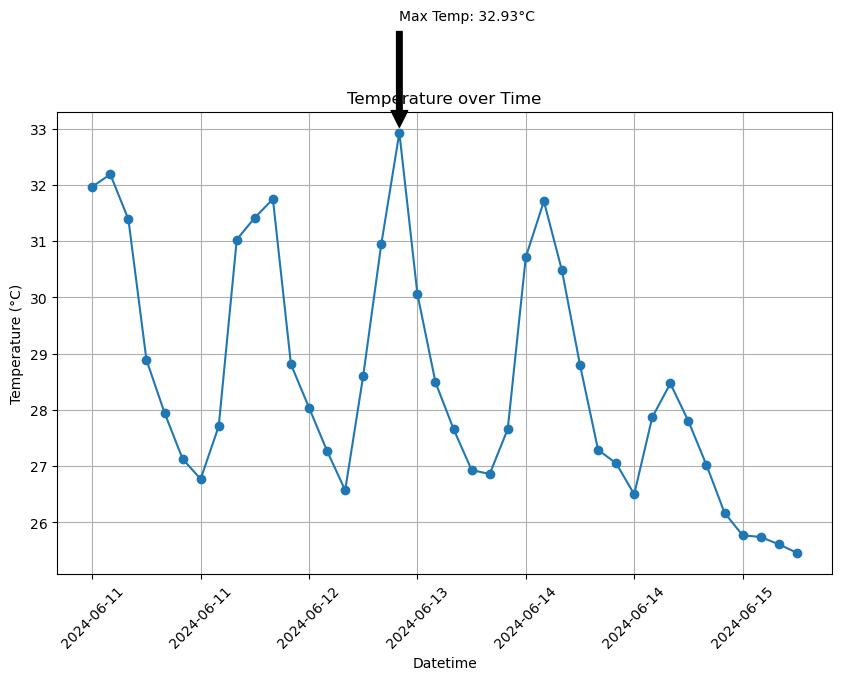

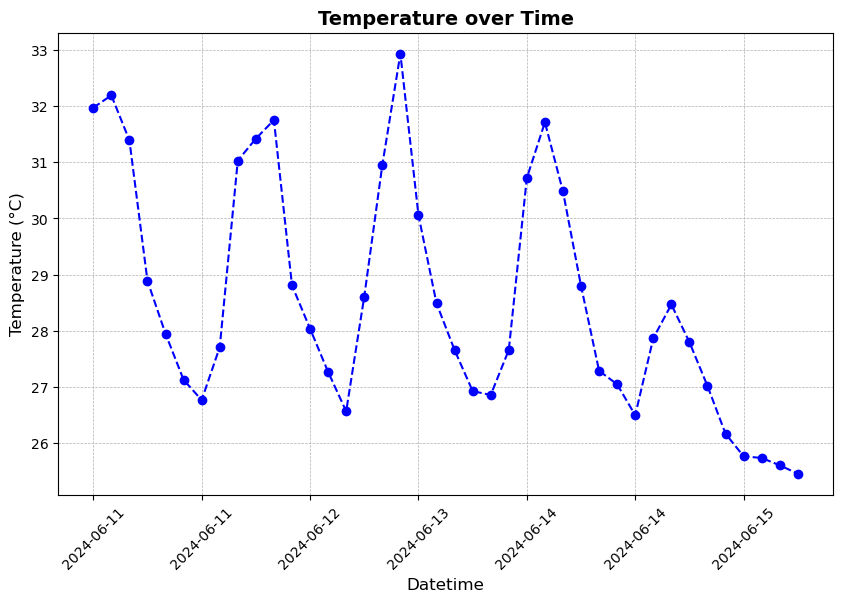

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("C:/Users/86185/SCNU/weather-dashboard-rendered-main (2)/weather-dashboard-rendered-main/notebooks/weather_forecast_data.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()
# Select every 6th datetime value for x-ticks
x_ticks = df['Datetime'][::6]

plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Temperature (C)'], marker='o')
plt.title('Temperature over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.xticks(ticks=x_ticks, rotation=45)
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.bar(df['Datetime'], df['Humidity (%)'], color='skyblue')
plt.title('Humidity over Time')
plt.xlabel('Datetime')
plt.ylabel('Humidity (%)')
plt.xticks(ticks=x_ticks, rotation=45)
plt.show()
weather_counts = df['Weather'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Weather Description Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(df['Temperature (C)'], df['Wind Speed (m/s)'], c='g', marker='o')
plt.title('Temperature vs. Wind Speed')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Temperature (C)'], marker='o')
plt.title('Temperature over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.xticks(ticks=x_ticks, rotation=45)
plt.grid(True)

# Annotate the highest temperature
max_temp = df['Temperature (C)'].max()
max_temp_time = df.loc[df['Temperature (C)'] == max_temp, 'Datetime'].iloc[0]
plt.annotate(f'Max Temp: {max_temp:.2f}°C', xy=(max_temp_time, max_temp), 
             xytext=(max_temp_time, max_temp+2), 
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Temperature (C)'], marker='o', linestyle='--', color='b')
plt.title('Temperature over Time', fontsize=14, fontweight='bold')
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(ticks=x_ticks, rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

In [2]:
import requests
import pandas as pd
api_key = "399b7d330c247da4e202f43b66680ae2"
url = f"http://www.airnowapi.org/aq/observation/zipCode/current?format=application/json&zipCode=90210&distance=25&API_KEY={api_key}"

response = requests.get(url)
if response.status_code == 200:
    air_quality_data = response.json()
    air_quality_data
else:
    print(f"Failed to fetch data: {response.status_code}")
air_quality_df = pd.DataFrame(air_quality_data)
combined_df = pd.merge(weather_df, air_quality_df, left_on='Date', right_on='Date', how='inner')
combined_df

Failed to fetch data: 401


NameError: name 'air_quality_data' is not defined

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import Project 
import matplotlib.patches as patches
from Project import fetch_weather_data
from Project import process_weather_data
from Project import determine_weather

def determine_weather(row, sunny_threshold, rainy_min_temp_threshold, rainy_humidity_threshold):
    if row['Max Temperature (C)'] > sunny_threshold:
        return 'Sunny'
    elif row['Min Temperature (C)'] < rainy_min_temp_threshold and row['Max Humidity (%)'] > rainy_humidity_threshold:
        return 'Rainy'
    else:
        return 'Partly Cloudy'

# Dropdown for city selection
city_dropdown = widgets.Dropdown(
    options=['Sydney', 'New York', 'London', 'Beijing'],
    value='Sydney',
    description='City:'
)

# Button to fetch and update weather data
update_button = widgets.Button(
    description='Update Weather',
    button_style='success'
)

output = widgets.Output()

# Function to update weather data and plots
def update_weather(b):
    city = city_dropdown.value
    api_key = 'd0de46031ad7410d0c72c6063690e1d0'  # Replace with your OpenWeatherMap API key
    current_data, forecast_data = fetch_weather_data(api_key, city)
    current_df, hourly_df, daily_df = process_weather_data(current_data, forecast_data)
    daily_df['Weather'] = daily_df.apply(determine_weather, axis=1, args=(25, 15, 80))

    with output:
        output.clear_output()
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        fig.tight_layout(pad=5.0)

        # Generate plots
        wp.create_forecast_card(axs[0], daily_df.iloc[0]['Date'], daily_df.iloc[0]['Max Temperature (C)'], daily_df.iloc[0]['Min Temperature (C)'], daily_df.iloc[0]['Weather'])
        wp.plot_scatter(hourly_df, 'Temperature (C)', 'Wind Speed (m/s)', axs[1], title="Wind Speed vs Temperature")
        wp.plot_min_max(daily_df, 'Date', 'Min Temperature (C)', 'Max Temperature (C)', axs[2], title="Daily Min/Max Temperature")

        plt.show()

update_button.on_click(update_weather)
display(city_dropdown, update_button, output)
update_weather(None)

ImportError: cannot import name 'fetch_weather_data' from 'Project' (C:\Users\86185\SCNU\weather-dashboard-rendered-main (2)\weather-dashboard-rendered-main\notebooks\Project.py)

In [7]:
import tkinter as tk
from tkinter import ttk
import pandas as pd

def create_window():
    def fetch_weather():
        location = location_entry.get()
        # Fetch and display weather data for the entered location
        # This is a placeholder function, replace with actual data fetching logic
        weather_data_label.config(text=f"Weather data for {location}")

    window = tk.Tk()
    window.title("WeatherVista Dashboard")
    window.geometry("600x400")
    
    # Add a label
    label = ttk.Label(window, text="WeatherVista Dashboard", font=("Arial", 16))
    label.pack(pady=20)
    
    # Add entry field for location
    location_label = ttk.Label(window, text="Enter Location:")
    location_label.pack(pady=5)
    location_entry = ttk.Entry(window)
    location_entry.pack(pady=5)
    
    # Add a button to fetch weather data
    fetch_button = ttk.Button(window, text="Fetch Weather", command=fetch_weather)
    fetch_button.pack(pady=10)
    
    # Add a label to display weather data
    weather_data_label = ttk.Label(window, text="", font=("Arial", 12))
    weather_data_label.pack(pady=20)
    
    window.mainloop()

create_window()

import requests

def fetch_weather_data(api_key, location):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        weather_info = {
            "Location": data["name"],
            "Temperature (C)": data["main"]["temp"] - 273.15,
            "Humidity (%)": data["main"]["humidity"],
            "Weather": data["weather"][0]["description"]
        }
        return weather_info
    else:
        return None

def create_window():
    def fetch_weather():
        location = location_entry.get()
        weather_data = fetch_weather_data(api_key, location)
        if weather_data:
            weather_info = f"Location: {weather_data['Location']}\n"
            weather_info += f"Temperature: {weather_data['Temperature (C)']:.2f} °C\n"
            weather_info += f"Humidity: {weather_data['Humidity (%)']}%\n"
            weather_info += f"Weather: {weather_data['Weather']}"
            weather_data_label.config(text=weather_info)
        else:
            weather_data_label.config(text="Failed to fetch data")

    window = tk.Tk()
    window.title("WeatherVista Dashboard")
    window.geometry("600x400")
    
    api_key = "399b7d330c247da4e202f43b66680ae2"
    
    # Add a label
    label = ttk.Label(window, text="WeatherVista Dashboard", font=("Arial", 16))
    label.pack(pady=20)
    
    # Add entry field for location
    location_label = ttk.Label(window, text="Enter Location:")
    location_label.pack(pady=5)
    location_entry = ttk.Entry(window)
    location_entry.pack(pady=5)
    
    # Add a button to fetch weather data
    fetch_button = ttk.Button(window, text="Fetch Weather", command=fetch_weather)
    fetch_button.pack(pady=10)
    
    # Add a label to display weather data
    weather_data_label = ttk.Label(window, text="", font=("Arial", 12))
    weather_data_label.pack(pady=20)
    
    window.mainloop()

create_window()